In [1]:
from langgraph.graph import StateGraph, END
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import os
from typing import Optional
from dotenv import load_dotenv
from IPython.display import  Image, display

In [2]:
load_dotenv()
openai_api_key=os.getenv('OPENAI_API_KEY')

In [3]:
llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", openai_api_key=openai_api_key)

# Definição do estado
class State(dict):
    mensagem: str
    proposta: Optional[str]
    avaliacao: Optional[str]
    revisao_final: Optional[str]
    resultado: Optional[str]

# Função para criar estado inicial
def criar_estado_inicial(problema):
    return {
        "mensagem": problema,
        "proposta": None,
        "avaliacao": None,
        "revisao_final": None,
        "resultado": None
    }

# Nó 1: Gerar proposta
def agente_gerador(state):
    prompt = ChatPromptTemplate.from_template(
        "Proponha uma solução para o seguinte problema:\n{mensagem}\n"
        "Considere críticas anteriores: {avaliacao}"
    )
    resposta = llm.invoke(prompt.format_messages(
        mensagem=state["mensagem"],
        avaliacao=state["avaliacao"] or "Nenhuma crítica ainda."
    ))
    state["proposta"] = resposta.content.strip()
    return state

# Nó 2: Avaliar proposta
def agente_critico(state):
    prompt = ChatPromptTemplate.from_template(
        "Aqui está uma proposta: {proposta}\nAvalie se está boa ou precisa melhorar. "
        "Responda apenas com 'aprovada' ou uma crítica construtiva."
    )
    resposta = llm.invoke(prompt.format_messages(
        proposta=state["proposta"]
    ))
    state["avaliacao"] = resposta.content.strip().lower()
    return state

# Nó 3: Revisar proposta final
def revisor_final(state):
    prompt = ChatPromptTemplate.from_template(
        "Revise cuidadosamente esta proposta:\n{proposta}\n"
        "Se estiver boa, diga 'Tudo certo'. Se precisar, sugira melhorias finais."
    )
    resposta = llm.invoke(prompt.format_messages(
        proposta=state["proposta"]
    ))
    state["revisao_final"] = resposta.content.strip()
    state["resultado"] = f"Proposta finalizada: {state['proposta']} | Revisão: {state['revisao_final']}"
    return state

# Função de decisão: para onde ir depois do Crítico
def escolher_proximo(state):
    if "aprovada" in state["avaliacao"]:
        return "revisor_final"
    else:
        return "agente_gerador"

# Construção do grafo
graph = StateGraph(State)

graph.add_node("agente_gerador", agente_gerador)
graph.add_node("agente_critico", agente_critico)
graph.add_node("revisor_final", revisor_final)

graph.set_entry_point("agente_gerador")
graph.add_edge("agente_gerador", "agente_critico")
graph.add_conditional_edges("agente_critico", escolher_proximo)
graph.add_edge("revisor_final", END)

app = graph.compile()

C:\Users\alber\AppData\Local\Temp\ipykernel_12956\2770061743.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", openai_api_key=openai_api_key)


In [5]:
estado_inicial = criar_estado_inicial("Reduzir o tempo de resposta de um chatbot para menos de 1 segundo.")
resultado = app.invoke(estado_inicial)

print("\n--- Resultado Final ---")
print(resultado["resultado"])



--- Resultado Final ---
Proposta finalizada: Para reduzir o tempo de resposta de um chatbot para menos de 1 segundo, é importante atuar em várias frentes que impactam diretamente a latência do sistema. Abaixo, proponho uma solução estruturada com medidas técnicas e arquiteturais:

### 1. Otimização do modelo de linguagem
- **Modelos mais leves:** Utilize modelos de linguagem menores e otimizados, como distilados (DistilBERT, TinyBERT) ou versões quantizadas que mantêm boa qualidade com menor custo computacional.
- **Pruning e quantização:** Aplique técnicas de pruning (remoção de neurônios irrelevantes) e quantização (redução da precisão dos pesos) para acelerar a inferência.

### 2. Infraestrutura e arquitetura
- **Servidores próximos ao usuário:** Utilize CDNs ou servidores edge para executar o chatbot o mais próximo possível do usuário, reduzindo latência de rede.
- **GPU/TPU:** Utilize hardware acelerado para inferência, como GPUs ou TPUs, para agilizar o processamento.
- **Serviç

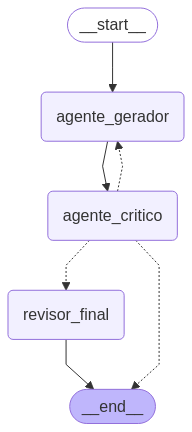

In [6]:
display(Image(app.get_graph().draw_mermaid_png()))